# Prosper Loan Data Exploration
## by Dina El-kholy

## Preliminary Wrangling

> This dataset contains information about 113,937 loans represented by 81 features such as the loan amount, the monthly income, the employment status, and the loan status. More information about the dataset features can be found [here](https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0).

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import zscore
%matplotlib inline

In [2]:
# load in the dataset into a pandas dataframe, print statistics
loans = pd.read_csv('prosperLoanData.csv')

In [3]:
loans.shape

(113937, 81)

In [4]:
loans.head(2)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.158,0.138,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.092,0.082,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1


In [5]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

> Many of the features are not useful for the analysis; so, the irrelevant columns should be dropped.

In [6]:
#select columns from the dataset
sub_cols = ["LoanStatus", "LoanOriginalAmount", "StatedMonthlyIncome", "DebtToIncomeRatio", "Term"
            ,"EmploymentStatus", "EmploymentStatusDuration", "Occupation", "ListingCategory (numeric)",
            "TotalProsperLoans"]
loans_sub = loans[sub_cols]
loans_sub.head(2)

,LoanStatus,LoanOriginalAmount,StatedMonthlyIncome,DebtToIncomeRatio,Term,EmploymentStatus,EmploymentStatusDuration,Occupation,ListingCategory (numeric),TotalProsperLoans
0,Completed,9425,3083.333333,0.17,36,Self-employed,2.0,Other,0,NaN
1,Current,10000,6125.000000,0.18,36,Employed,44.0,Professional,2,NaN


In [7]:
#remove cancelled as it is considered as an outlier
loans_sub.drop(loans_sub[loans_sub['LoanStatus'] =="Cancelled"].index, inplace = True)

/home/dina/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
#modify the values in LoanStatus such that the values can only be [Current, Completed, Defaulted,
#                                                                  FinalPaymentInProgress, PastDue]
keep_vals = ["Current", "Completed", "Defaulted","FinalPaymentInProgress"]
cond = loans_sub.LoanStatus.isin(keep_vals)
loans_sub.loc[~cond, "LoanStatus"] = "PastDue"

/home/dina/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [9]:
loans_sub["LoanStatus"].value_counts()

Current                   56576
Completed                 38074
PastDue                   14059
Defaulted                  5018
FinalPaymentInProgress      205
Name: LoanStatus, dtype: int64

In [10]:
#check for null values
loans_sub.isna().sum()

LoanStatus                       0
LoanOriginalAmount               0
StatedMonthlyIncome              0
DebtToIncomeRatio             8554
Term                             0
EmploymentStatus              2252
EmploymentStatusDuration      7621
Occupation                    3585
ListingCategory (numeric)        0
TotalProsperLoans            91847
dtype: int64

In [11]:
#replace null in TotalProsperLoans with zeros
loans_sub['TotalProsperLoans'] = loans_sub['TotalProsperLoans'].fillna(0)

<ipython-input-11-1c2154f0a104>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans_sub['TotalProsperLoans'] = loans_sub['TotalProsperLoans'].fillna(0)


In [12]:
#drop rows with null values
loans_sub = loans_sub.dropna()
loans_sub.isna().sum()

LoanStatus                   0
LoanOriginalAmount           0
StatedMonthlyIncome          0
DebtToIncomeRatio            0
Term                         0
EmploymentStatus             0
EmploymentStatusDuration     0
Occupation                   0
ListingCategory (numeric)    0
TotalProsperLoans            0
dtype: int64

In [13]:
#check for duplicates
sum(loans_sub.duplicated())

736

In [14]:
#drop duplicates
loans_sub = loans_sub.drop_duplicates()

In [15]:
#check how much data we have
loans_sub.shape

(95824, 10)

> Check some statistics about the data

In [16]:
loans_sub.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LoanOriginalAmount,95824.0,8685.584259,6363.032075,1000.0,4000.000000,7000.000000,12500.00,35000.000000
StatedMonthlyIncome,95824.0,5741.778438,4931.768469,0.0,3333.333333,4866.666667,7000.00,483333.333333
DebtToIncomeRatio,95824.0,0.275814,0.529839,0.0,0.150000,0.220000,0.32,10.010000
Term,95824.0,41.305477,10.779414,12.0,36.000000,36.000000,36.00,60.000000
EmploymentStatusDuration,95824.0,97.058159,93.420456,0.0,27.000000,69.000000,139.00,755.000000
ListingCategory (numeric),95824.0,2.940318,4.081797,0.0,1.000000,1.000000,3.00,20.000000
TotalProsperLoans,95824.0,0.291973,0.669145,0.0,0.000000,0.000000,0.00,8.000000


### What is the structure of your dataset?

> There are 113937 loan records in the dataset described by 81 features. The features are either numeric or categorical.  

### What is/are the main feature(s) of interest in your dataset?

> I want to figure out which features contribute the most in completing or defaulting a loan.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> The dataset contains a huge number of features. I will focus on the LoanStatus, LoanOriginalAmount, StatedMonthlyIncome, DebtToIncomeRatio, Term,EmploymentStatus, EmploymentStatusDuration, Occupation, ListingCategory, and TotalProsperLoans.

## Univariate Exploration

> I will start by checking the main variable of interest, LoanStatus.

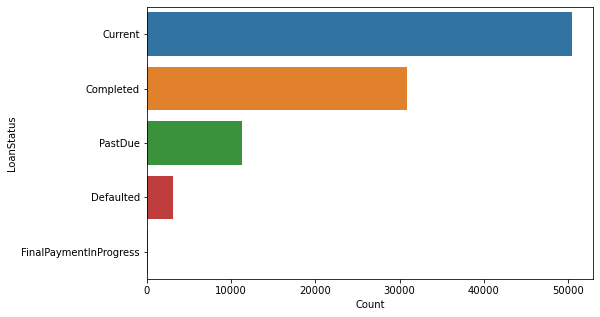

In [17]:
# Visulizing the loan status
plt.figure(figsize=[8, 5])
status = loans_sub['LoanStatus'].value_counts().index
sb.countplot(data=loans_sub, y='LoanStatus', order=status);
plt.xlabel('Count');

> It looks like most loans are paid as expected. However, some are defaulted or past due; I want to inspect whether any of the features can explain the delay?

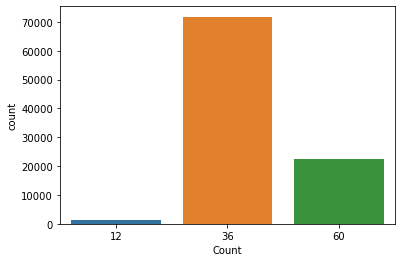

In [18]:
# Visulizing the time periods for loans
sb.countplot(data = loans_sub, x = 'Term');
plt.xlabel('Count');

> Most loans are 36 months.

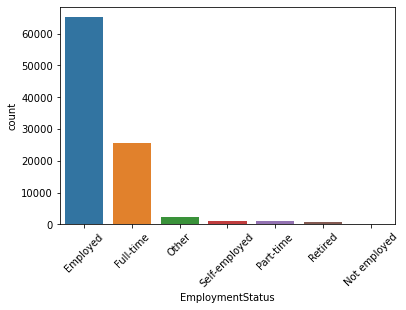

In [19]:
#visualize employment status
status = loans_sub['EmploymentStatus'].value_counts().index
sb.countplot(data=loans_sub, x='EmploymentStatus', order = status)
plt.xticks(rotation=45);

>As expected, people with a stable job are favored in the loan process. Is a certain occupation more favored as well?

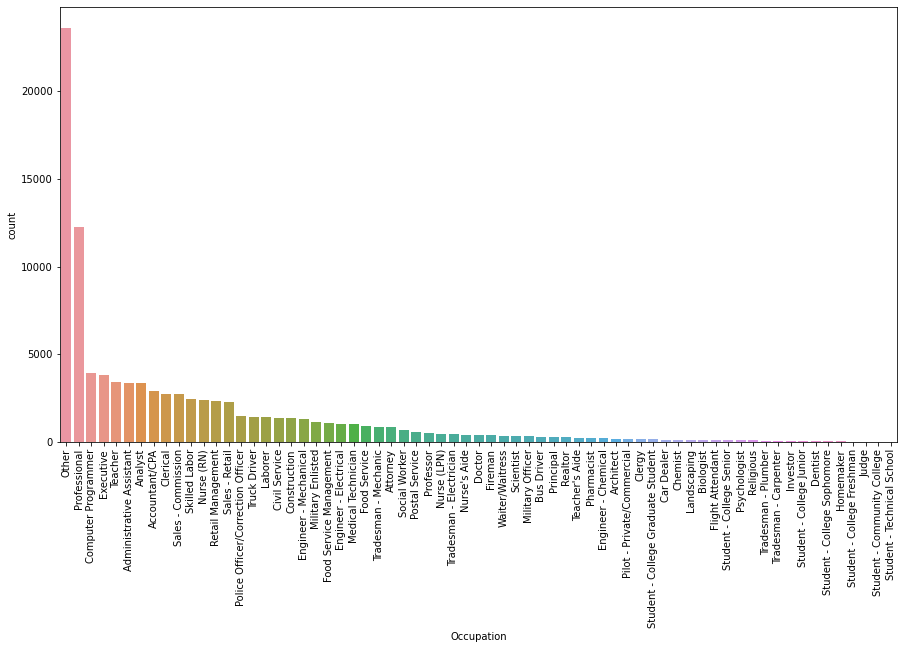

In [20]:
#visualize occupation
plt.figure(figsize=[15, 8])
status = loans_sub['Occupation'].value_counts().index
sb.countplot(data=loans_sub, x='Occupation', order = status);
plt.xticks(rotation = 90);

> Students are the least favored in the loan process. Trademen are the second least favored. In the case of the students, I believe this is logical as students need loans less. I think in the case of the trademen, it is because their job is not stable and they may not be able to pay regularly.

In [21]:
loans_sub['DebtToIncomeRatio'].describe()

count    95824.000000
mean         0.275814
std          0.529839
min          0.000000
25%          0.150000
50%          0.220000
75%          0.320000
max         10.010000
Name: DebtToIncomeRatio, dtype: float64

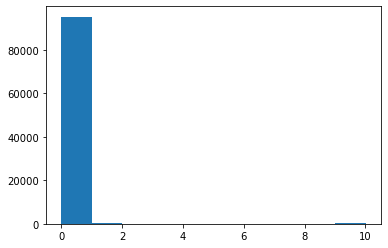

In [22]:
#visualize the debt to income ration
plt.hist(data=loans_sub, x='DebtToIncomeRatio', bins =10);

> DebtToIncomeRatio is one's monthly debt payments divided by his/her gross monthly income. In most loans, the monthly debt is 32% of one's monthly income.

In [23]:
loans_sub['StatedMonthlyIncome'].describe()

count     95824.000000
mean       5741.778438
std        4931.768469
min           0.000000
25%        3333.333333
50%        4866.666667
75%        7000.000000
max      483333.333333
Name: StatedMonthlyIncome, dtype: float64

Discard outliers <br> There is a huge difference between the mean and the max value. We can not visualize the data like this. Since, we care about the majority of loans, I will discard any value that is far from the mean by more than 3 standard deviations.

In [24]:
#define the outliers' boundary
limit = loans_sub['StatedMonthlyIncome'].mean() + 3*loans_sub['StatedMonthlyIncome'].std()
print("Limit = ", limit)
print("# of ourliers = ", len(loans_sub[loans_sub['StatedMonthlyIncome']>limit]))

Limit =  20537.083845221205
# of ourliers =  905


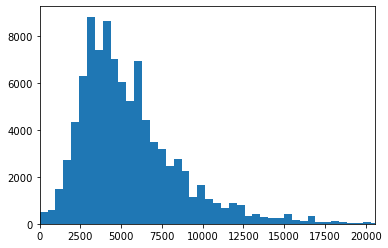

In [25]:
#visualize the income
plt.hist(data=loans_sub, x='StatedMonthlyIncome', bins =1000);
plt.xlim(0,limit);

> The averge income is skewed towards the right and the avergae income is 5000. 

In [26]:
#check the loan original amount
loans_sub['LoanOriginalAmount'].describe()

count    95824.000000
mean      8685.584259
std       6363.032075
min       1000.000000
25%       4000.000000
50%       7000.000000
75%      12500.000000
max      35000.000000
Name: LoanOriginalAmount, dtype: float64

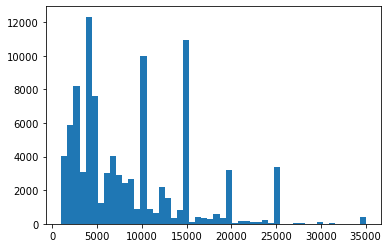

In [27]:
#visualize the income
plt.hist(data=loans_sub, x='LoanOriginalAmount', bins =50);

> Most loans are less than 15K.

In [28]:
#ListingCategory
categ = ["Not Available","Debt Consolidation","Home Improvement","Business","Personal Loan","Student Use"
         ,"Auto","Other","Baby&Adoption","Boat","Cosmetic Procedure","Engagement Ring","Green Loans",
         "Household Expenses","Large Purchases","Medical/Dental","Motorcycle","RV"
         ,"Taxes","Vacation","Wedding Loans"]
loans_sub['ListingCategory (numeric)']= loans_sub['ListingCategory (numeric)'].apply(lambda x: categ[x])

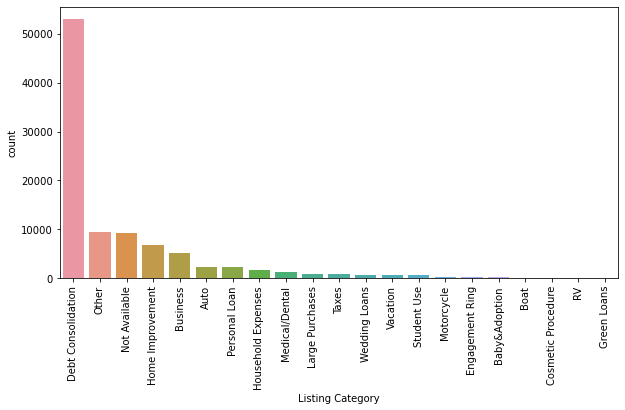

In [29]:
#ListingCategory
plt.figure(figsize=[10, 5])
status = loans_sub['ListingCategory (numeric)'].value_counts().index
sb.countplot(data=loans_sub, x='ListingCategory (numeric)', order = status);
plt.xlabel("Listing Category")
plt.xticks(rotation = 90);

> Most loans are taken to pay debt.

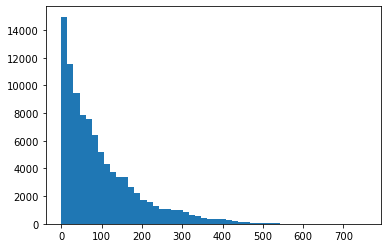

In [30]:
#visualize EmploymentStatusDuration
plt.hist(data=loans_sub, x='EmploymentStatusDuration', bins =50);

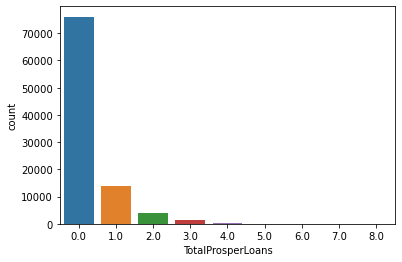

In [31]:
#TotalProsperLoans
sb.countplot(data=loans_sub, x='TotalProsperLoans');

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> - Most loans are current or completed loans. Almost none of the loans are cancelled.
> - Most loans are listed as Debt Consolidation. However, many borrowers did not report a listing category. 
> - Most loans are bellow 15K.
> - The average monthly income of borrowers is 5000. However, the overall distribution of the values is not uniform with many outliers. I did not perform any transformations; however, I discarded the outliers.
> - Almost all borrowers are employed. 
> - The term of most loans is 36 months.
> - Most borrowers have not occupied their current job for very long (which is weird?)
> - Most borrowers have no previous loans.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> - The ListingCategory feature is not intuitive; so, I modified the the labels to their name. 
> - In the LoanStatus feature, I combined all the past due periods to be just Pastdue as we don't care about the period of past due loans. 
> - I removed the outliers during the visualization of the monthly income. In order to have a successful analysis, I will now remove any client whose monthly income is more than 20537$. This will result in removing 905 rows from the dataset.

In [32]:
#remove outliers
loans_sub = loans_sub[loans_sub['StatedMonthlyIncome']<limit]
loans_sub.shape

(94919, 10)

## Bivariate Exploration

> Let's first see a correlation plot between all the numeric categories.

In [33]:
numeric_cols = ["LoanOriginalAmount", "StatedMonthlyIncome", "DebtToIncomeRatio", "Term",
                "EmploymentStatusDuration","TotalProsperLoans"]
categorical_cols = ["LoanStatus","EmploymentStatus","Occupation", "ListingCategory (numeric)"]

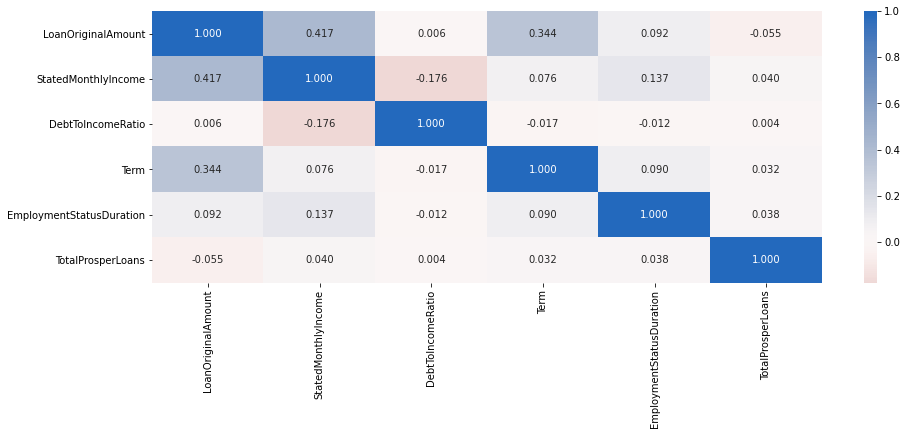

In [34]:
# correlation plot between all numeric columns
plt.figure(figsize = [15, 5])
sb.heatmap(loans_sub[numeric_cols].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

> From the map, one can see that there is no strong correlation between any of the features. However, the loan amount and the monthly income seem to be correlated. Also, the term of the loan and the loan amount are correlated. There is also a negative correlation between the monthly income and the debt to income ratio which is expected.

Now, let's visualize the relation between different categorical features with the numerical features:

<Figure size 1080x720 with 0 Axes>

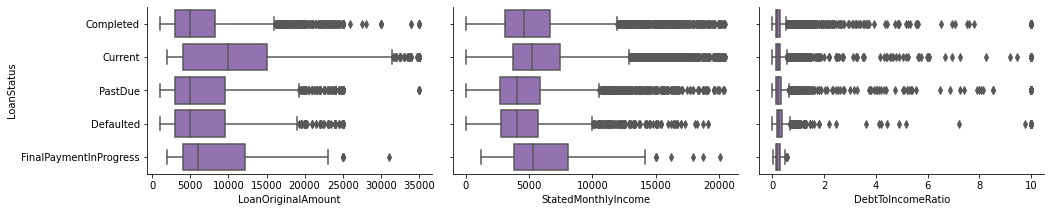

In [35]:
#box grid between different categorical values and the LoanStatus
def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[4]
    sb.boxplot(x=x, y=y, color = default_color);

x_vars = ["LoanOriginalAmount", "StatedMonthlyIncome","DebtToIncomeRatio" ]
y_vars = ["LoanStatus"]
plt.figure(figsize = [15, 10]);
g = sb.PairGrid(data = loans_sub, y_vars = y_vars, x_vars = x_vars,
                height = 3, aspect = 1.5);
g.map(boxgrid);
plt.show();

> - From the plots, one can see that there are many outliers in the data especially in the DebtToIncomeRatio feature. 
>- Also, we can see that the distribution of the pastDue and the Defaulted loans are nearly the same in regards to the loan amount and the monthly income. I think it will be safe to assume that past due loans will be defaulted eventually. Hence, we can label them all as defaulted loans. I will do that in a future step. 
> - Borrowers with Completed or final payment in progress loans seem to have higher income that the borrowers whose loans were defaulted.  

In [36]:
#combine defaulted and past due loans
cond = loans_sub.LoanStatus == "PastDue"
loans_sub.loc[cond, "LoanStatus"] = "Defaulted"
loans_sub['LoanStatus'].value_counts()

Current                   49899
Completed                 30584
Defaulted                 14252
FinalPaymentInProgress      184
Name: LoanStatus, dtype: int64

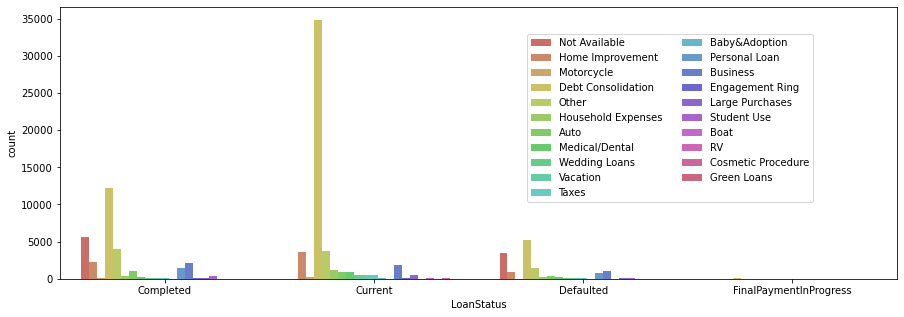

In [37]:
#loan status vs listing category
plt.figure(figsize = [15, 5]);
sb.countplot(data=loans_sub, x='LoanStatus', hue='ListingCategory (numeric)', palette='hls');
plt.legend(bbox_to_anchor=(0.9, 0.9),
           borderaxespad=0, ncol=2);

> Most loans are for debt consolidations (for any loan type) as found before.

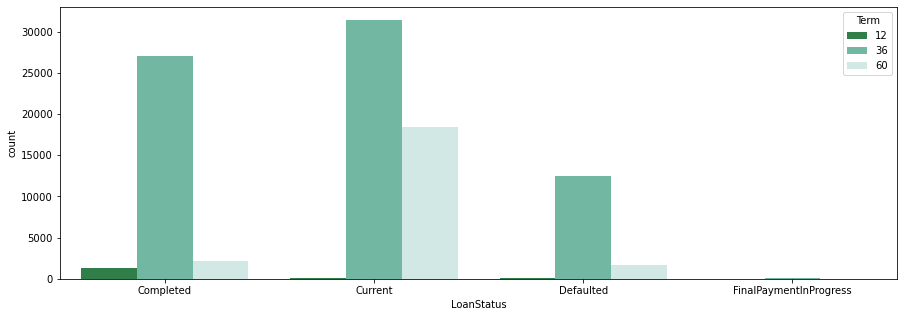

In [38]:
#loan status vs loan's term
plt.figure(figsize = [15, 5]);
sb.countplot(data=loans_sub, x='LoanStatus', hue='Term', palette='BuGn_r');

> Most loans are 36 months (for any loan type) as found before. 

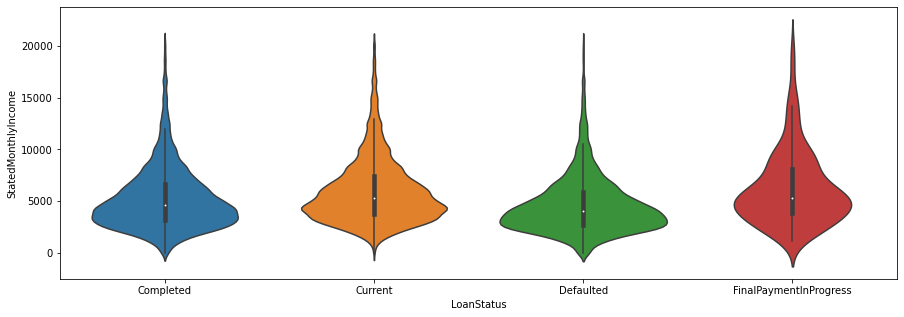

In [39]:
#loan status vs monthly income
plt.figure(figsize = [15, 5]);
sb.violinplot(data = loans_sub, x = 'LoanStatus', y = 'StatedMonthlyIncome');

> Defaulted loans usually have less monthly income.

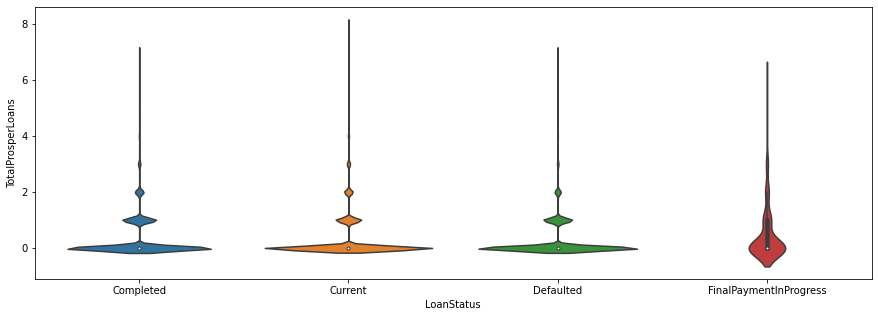

In [40]:
#loan status vs total prosper loans
plt.figure(figsize = [15, 5]);
sb.violinplot(data = loans_sub, x = 'LoanStatus', y = 'TotalProsperLoans');

> It seems that total prosper loans feature does not add any new information.

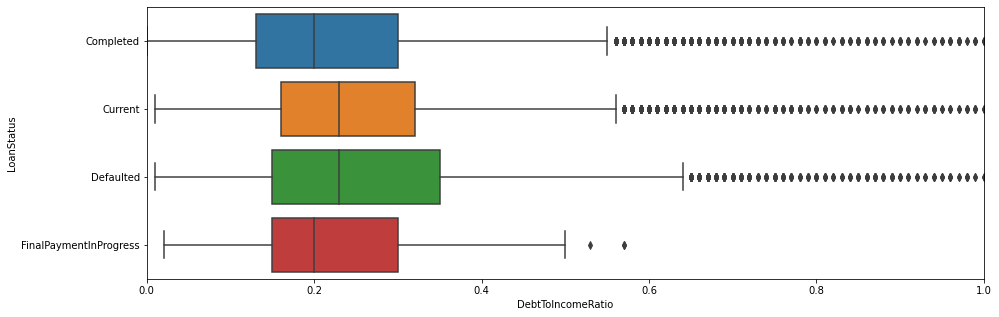

In [41]:
#loan status vs debt to income ratio
plt.figure(figsize = [15, 5]);
sb.boxplot(data = loans_sub, y='LoanStatus', x='DebtToIncomeRatio');
plt.xlim(0,1); #All values after 1 are outliers

> The completed loans have less debt to income ratio.

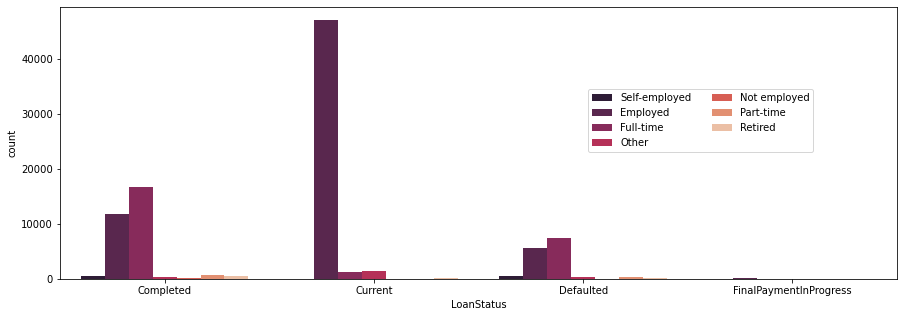

In [42]:
#employment and loan status
plt.figure(figsize = [15, 5]);
sb.countplot(data=loans_sub, x='LoanStatus', hue='EmploymentStatus', palette='rocket');
plt.legend(bbox_to_anchor=(0.9, 0.7),
           borderaxespad=0, ncol=2);

> Most completed loans are fulfilled by full-time employed borrowers. 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> - Borrowers with Completed or final payment in progress loans seem to have higher income that the borrowers whose loans were defaulted.
> - Completed loans have lower debt to income ratio.
> - The term of most loans, from all types, is 36 months.
> - The purpose of most loans is debt consolidations.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> - The loan original amount and the monthly income are positively correlated.
> - The term of the loan and loan amount are positively correlated. 

## Multivariate Exploration

> Let's take a closer look on the relation between different variables and the loan status:

For this part, I will focus only on defaulted and completed loans for better visualization:

In [48]:
keep_vals = ["Completed", "Defaulted"]
cond = loans_sub.LoanStatus.isin(keep_vals)
loans_vis = loans_sub[cond]

In [44]:
def cuberoot_trans(x, inverse = False):
    """ quick function for computing cube root and cube operations """
    if not inverse:
        return x ** (1/3)
    else:
        return x ** 3
    
def hist2dgrid(x, y, **kwargs):
    """ Quick hack for creating heat maps with seaborn's PairGrid. """
    palette = kwargs.pop('color')
    plt.hist2d(x, y, bins = [50, 50], cmap = palette)
    
numeric_cols = ["LoanOriginalAmount", "StatedMonthlyIncome", "DebtToIncomeRatio", "Term",
                "EmploymentStatusDuration","TotalProsperLoans"]


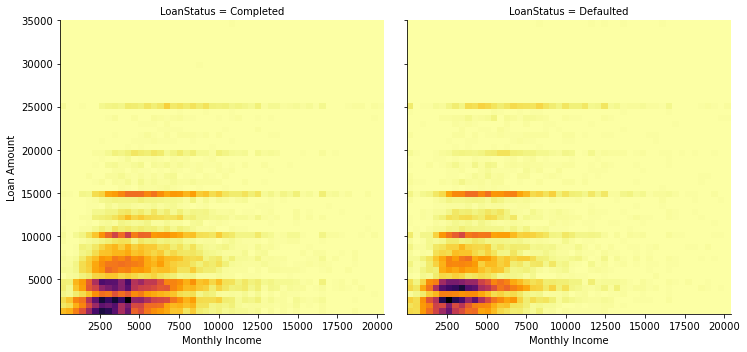

In [45]:
# create faceted heat maps on levels of the loan status variable
g = sb.FacetGrid(data = loans_vis, col = 'LoanStatus', col_wrap = 4, height = 5)
g.map(hist2dgrid, 'StatedMonthlyIncome', 'LoanOriginalAmount', color = 'inferno_r', annot=True)
g.set_ylabels('Loan Amount')
g.set_xlabels('Monthly Income')

plt.show()

> There is no noticable difference in the distribution of those two variables regarding different loan types.

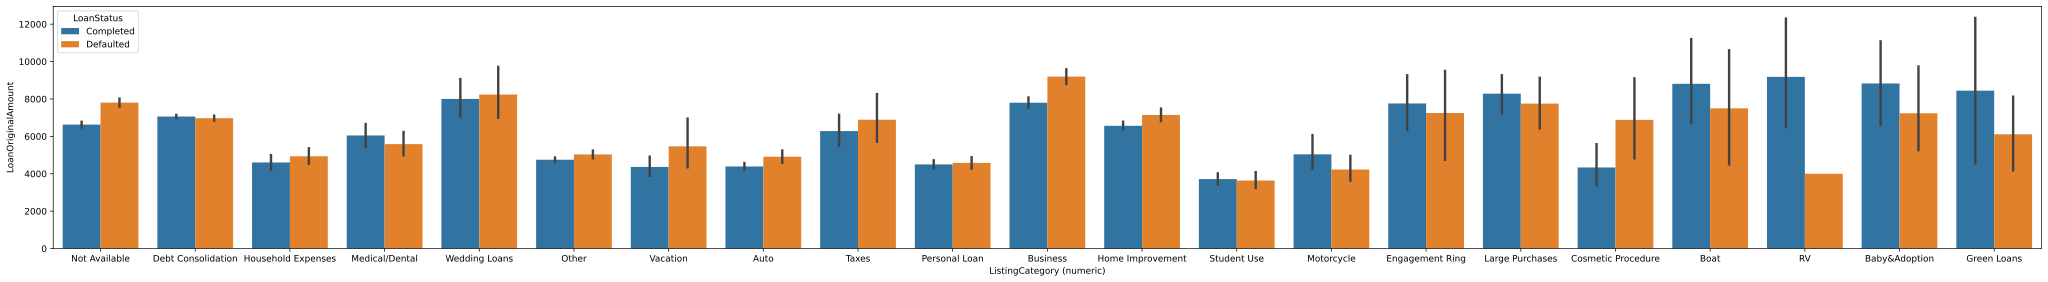

In [46]:
%config InlineBackend.figure_format = 'svg' #for this image to be clear
plt.figure(figsize = [40, 5])
sb.barplot(data= loans_vis, x='ListingCategory (numeric)', y='LoanOriginalAmount',
           hue='LoanStatus');
g.set_ylabels('Loan Amount')
g.set_xlabels('Listed Loan Category')

> Loans with higher original amount are defaulted more often for the same listing category except in categories as medical/dental, student use, motorcycle, engagement ring, large purchases, adoption, and green loans. I think it is related to priority and whether it is an essential need. Moreover, adoption and student use, for example, are essential needs so borrowers tend to complete these loans. On the other hand, when the loan is listed as vacation or cosmetic procedure, the loan is defaulted more often as these are not essential needs. I expected the engagement ring and wedding expenses listed loans to be defaulted or completed with the same rate as they should hold the same priority. However, I think getting engaged is more important than having a fancy wedding.

Let's check if there are other reasons for completing or defaulting the loans other than the purpose of the loan:

Text(0.5, 0, 'Employment Status')

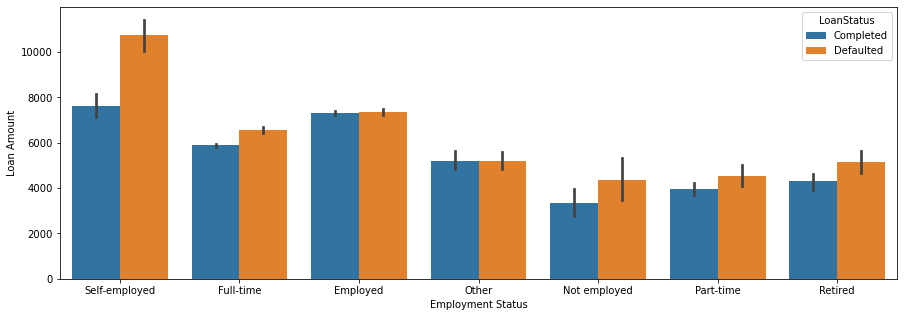

In [47]:
%config InlineBackend.figure_format = 'png' #for this image to be clear
#check if the employment status has an effect
plt.figure(figsize = [15, 5]);
sb.barplot(data= loans_vis, x='EmploymentStatus', y='LoanOriginalAmount',
           hue='LoanStatus');
plt.ylabel('Loan Amount')
plt.xlabel('Employment Status')

> - Loans with higher loan amount are usually defaulted as expected. 
> - Self-employed tend to request the largest loans while not employed borrowers tend to request the lowest loans (expected).
> - Full time borrowers tend to request higher loans than part time borrowers (expected).

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> - The amount of loan is affected by the listed category of the loan. Most loans with high loan amount are rejected. However, in some categories, higher loans are completed. I believe this is related to how important is that category. Moreover, higher loans tend to be completed in cases of adoption or medical/dental categories which are important human needs.
> - I investigated whether the employment status also is a factor. I found that high loans are defaulted more often in all employment categories. However, I found that self-employed borrowers tend to request the highest loan amount.

### Were there any interesting or surprising interactions between features?

> The weird observation about this dataset is that the features are not really correlated. Moreover, the only clear conclusion I have is that the loan status is related to the loan amount. Consequently, the status is related to the importance of the listed category of the loan.